This notebook explores FEMA flooding risk data for Harris county.

In [1]:
%matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal, ogr, osr
import mplleaflet
import pandas as pd

In [17]:
gdf = gpd.read_file('/',
                    vfs='zip://../hae_fema/48201C_20170602.zip',
                    driver='ESRI Shapefile',
                    layer='S_FLD_HAZ_AR')

In [18]:
gdf.columns

Index(['AR_REVERT', 'AR_SUBTRV', 'BFE_REVERT', 'DEPTH', 'DEP_REVERT',
       'DFIRM_ID', 'DUAL_ZONE', 'FLD_AR_ID', 'FLD_ZONE', 'LEN_UNIT', 'SFHA_TF',
       'SOURCE_CIT', 'STATIC_BFE', 'STUDY_TYP', 'VELOCITY', 'VEL_UNIT',
       'VERSION_ID', 'V_DATUM', 'ZONE_SUBTY', 'geometry'],
      dtype='object')

The categories:
* [AE](https://www.fema.gov/zone-ae-and-a1-30): Areas subject to inundation by the 1-percent-annual-chance flood event determined by detailed methods.
* [A](https://www.fema.gov/zone): Areas subject to inundation by the 1-percent-annual-chance flood event generally determined using approximate methodologies.
* [AO](https://www.fema.gov/zone-ao): Areas subject to inundation by 1-percent-annual-chance shallow flooding (usually sheet flow on sloping terrain) where average depths are between one and three feet.
* [VE](https://www.fema.gov/zone-ve-and-v1-30): Areas subject to inundation by the 1-percent-annual-chance flood event with additional hazards due to storm-induced velocity wave action.
* [X](): between 100 and 500 year flood, or less likely. ("Shaded" v "unshaded", does not appear to be in this dataset.)

In [19]:
high_risk = gdf[
    np.logical_and(
        gdf['FLD_ZONE'] != 'X',
        gdf['FLD_ZONE'] != 'AREA NOT INCLUDED'
    )
]

In [20]:
high_risk.loc[high_risk['DEPTH']==-9999, 'DEPTH'] = None
high_risk.loc[high_risk['VELOCITY']==-9999, 'VELOCITY'] = None

S:\programs\x64\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
set(high_risk['VEL_UNIT'])

{None, 'NP'}

In [22]:
from collections import Counter
Counter(high_risk['FLD_ZONE']).most_common()

[('AE', 3652), ('VE', 150), ('A', 129), ('AO', 34)]

In [23]:
high_risk.to_file('high_flood_risk.geojson', driver='GeoJSON')

Wall time: 55.8 s


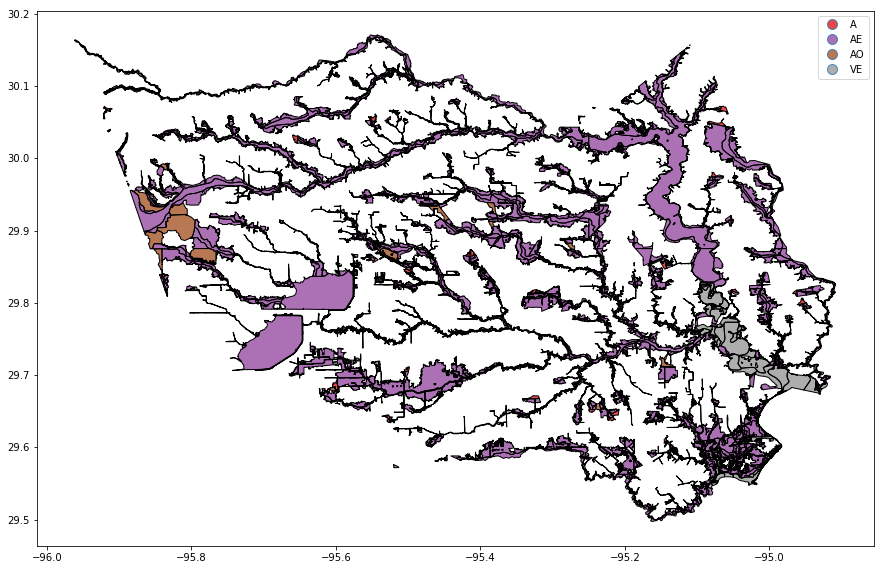

In [27]:
%%time
high_risk.plot(
    'FLD_ZONE',
    figsize=(15,15),
    categorical=True,
    cmap=plt.cm.Set1,
    alpha=0.8,
    legend=True
)

In [28]:
mplleaflet.show(tiles='osm') #('http://a.tile.openstreetmap.com/{z}/{x}/{y}.png', 'osm hot'))

In [30]:
high_risk_by_zone = high_risk.dissolve('FLD_ZONE', {
    'VELOCITY': np.mean,
    'DEPTH': np.mean,
})

In [31]:
high_risk_by_zone

,geometry,DEPTH,VELOCITY
FLD_ZONE,,,
A,(POLYGON ((-95.15508071016785 29.5444992699023...,NaN,NaN
AE,(POLYGON ((-95.5198929636889 29.57570418446915...,NaN,NaN
AO,(POLYGON ((-95.23445907130741 29.6511076854343...,1.794118,NaN
VE,(POLYGON ((-95.08908251845895 29.5954526061204...,NaN,NaN


In [39]:
high_risk_by_zone.to_file('high_risk.shp')

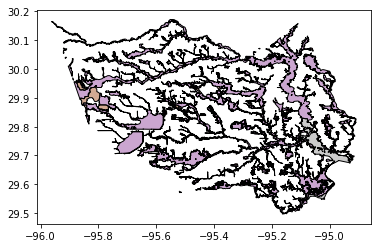

In [37]:
high_risk_by_zone.reset_index().plot('FLD_ZONE')